## ROMY Array

### Importing

In [16]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt 
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees
from andbro__querrySeismoData import __querrySeismoData
from tqdm import tqdm
from obspy.core.util import AttribDict

# frompydsm.relab import shiftdim

#from andbro__save_to import __save_to
#from andbro__get_data import __get_data


### Setting Variables

In [2]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2019-05-14T12:17:00.000")
config['tend'] = obspy.UTCDateTime("2019-05-14T14:00:10.000")


config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [3]:

def __plotArrayGeometryAndResponse(array, transff, klim, kstep, names=None, unit=None):
    
    ## calulcate geometrical center of array
    array_center = [np.median(array[:,0]), np.median(array[:,1])]
    
    ## find geometrical limits of array
    lon_min, lon_max = np.min(array[:,0]), np.max(array[:,0])
    lat_min, lat_max = np.min(array[:,1]), np.max(array[:,1])
    
    ## define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim
    
    
    ## _________________________________________________________
    ##
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12
    
    if unit is "km":
        xdata = (array[:,0]-array_center[0])*111.
        ydata = (array[:,1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)
    elif unit is "deg":
        xdata = array[:,0]
        ydata = array[:,1]
        x0, y0 = array_center[0], array_center[1]
        
    ## ________________________________________________
#     axes[0].plot(xdata, ydata,'kv')
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)
    
    if unit is "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
        axes[0].set_ylim([-max(abs(ydata)), max(abs(ydata))])
                 
    elif unit is "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)
                 
    axes[0].set_title('Square Array configuration', fontsize=fs+2)
    
    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x, y, s, ha="right", va="top")
    
    ## ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
               np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
               transff.T, cmap=obspy_sequential)
    
    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)
    
    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)
    
    plt.show()    


In [4]:

def __getArrayStations(seed_id, tbeg, tend, fur_coords):

    net, sta, loc, cha  = seed_id.split(".")

    route =  RoutingClient("eida-routing")
    inv_check =route.get_stations(
                            network=net, 
                            station=sta,
                            channel=cha,
                            starttime=tbeg,
                            endtime=tend,
                            latitude=fur_coords[0],
                            longitude=fur_coords[1],
                            minradius=0,
                            maxradius=0.1,
                            )
    
    
    inv_check.plot(projection="local");
    
    
    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(inv_check):
        for i, station in enumerate(network):
             
            codes.append(f'{inv_check[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)
            
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev':elev})
    
    return frame


In [5]:

def __calculateDistanceOfStations(array_stations):
    '''
    from obspy.geodetics import locations2degrees

    '''
    
    N = len(array_stations)
    
    dist_in_deg = np.zeros((N, N))

    for i, station1 in array_stations.iterrows():
        for j, station2 in array_stations.iterrows():
            dist_in_deg[i][j] = locations2degrees(lat1  = station1[2], 
                                                  long1 = station1[1], 
                                                  lat2  = station2[2], 
                                                  long2 = station2[1],
                                                  )
            
    return dist_in_deg, np.max(dist_in_deg)*111.0


In [6]:

# def __plotArraySection(st_in, scal, comp=None): 
    
#     if comp is not None:
#         st_in = st_in.select(component = comp);
#         title = f'{comp}-components of ROMY Array'
        
#     names = [tr.stats.station for tr in st_in]
    
#     fs = 14
    
#     ## _________________________________________
#     ##
#     fig, ax = plt.subplots(1,1, figsize=(13,6))
    
#     if len(st_in) > 50: 
#         print(f"only 50 of {len(st_in)} traces are plotted!")
#         st_in = st_in[:30]
        
#     for istation in range(len(st_in)):
#         tmp = st_in[istation].data
        
#         if len(tmp) == 0:
#             print('no data for station:', st_in[istation].stats.station)
        
#         else:
#             if scal > 0:
#                 tmp1 = tmp/(np.max(tmp)-np.min(tmp))
#             else:
#                 tmp1 = tmp
            
#             timeline = np.arange(0,len(tmp1),1)*st_in[istation].stats.delta
            
#             ax.plot(timeline, tmp1*np.abs(scal)+istation*np.abs(scal),'k')
    
#     ax.set_yticks(np.arange(0,len(st_in), 1)*scal)
#     ax.set_yticklabels(names, fontsize = fs)    
# #     ax.set_yticklabels(np.arange(0,len(st_in),1)+1)
#     ax.set_xlabel(f'Time from {st_in[0].stats.starttime.date} {st_in[0].stats.starttime.time} UTC (s)', fontsize = fs, labelpad=10)
#     ax.set_title(title, fontsize = fs)
    
#     plt.show();
#     return fig


In [7]:

# def __getStream(array_stations, tbeg, tend):
    
#     '''
#     from obspy.core.util import AttribDict

#     '''
    
#     ## request waveforms
#     st = obspy.Stream(traces=None)
#     for i, station in array_stations.iterrows():
#         print(f"requesting {station[0]}..BH* ...")

#         try:
#             st0, st_inv = __querrySeismoData(f"{station[0]}..BH*", tbeg, tend, restitute = True, details=None)
            
        
#         except:
#             print(f'--> failed for {station[0]}!')
        


#         st += st0
    
    
#     ## check for doubles
#     codes = []; removed = 0
#     for tr in st:
#         code = f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}"
#         if code in codes:
#             st.remove(tr)
#             removed += 1
#         else:
#             codes.append(code)
    
#     st.merge(); 
#     print(f'\n{removed} doubles have been removed!')
    
#     return st


### Obtain Station Information

In [8]:
## get station info of FUR

net, sta, loc, cha  = "GR.FUR..BHZ".split(".")
 
inv_fur = config['client'].get_stations(
                                        network = net, 
                                        station = sta,
                                        channel = cha,
                                        starttime = config['tbeg'],
                                        endtime = config['tend']
                                        ) 

fur_coords = [inv_fur[0][0].latitude, inv_fur[0][0].longitude, inv_fur[0][0].elevation]
fur_coords

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


[48.1639, 11.2768, 565.0]

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1.2, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


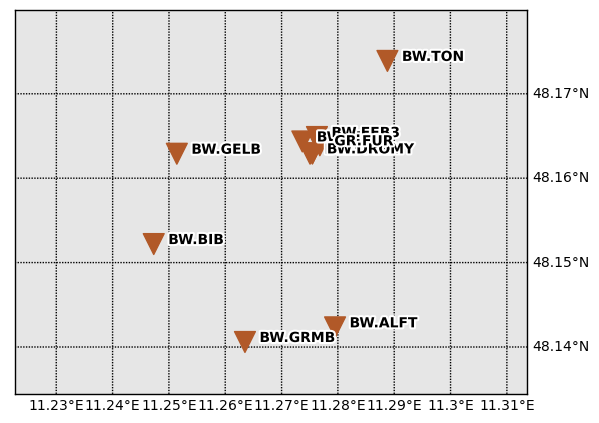

,codes,lon,lat,elev
0,BW.FFB2,11.273684,48.164357,0.577
1,BW.TON,11.288809,48.173897,0.564
2,BW.ALFT,11.279500,48.142334,0.593
3,BW.GELB,11.251400,48.162900,0.628
4,BW.GRMB,11.263500,48.140600,0.656
5,BW.ROMY,11.275476,48.162941,0.571
6,BW.BIB,11.247300,48.152200,0.599
7,BW.FFB1,11.275065,48.162904,0.572
8,BW.DROMY,11.275476,48.162941,0.571
9,BW.FFB3,11.276289,48.164883,0.562


In [9]:
## get all stations around ROMY

array_stations = __getArrayStations("*.*..B*Z", config['tbeg'], config['tend'], fur_coords)

array_stations

### Calulcate Distances, Plot Array Geometry and Response

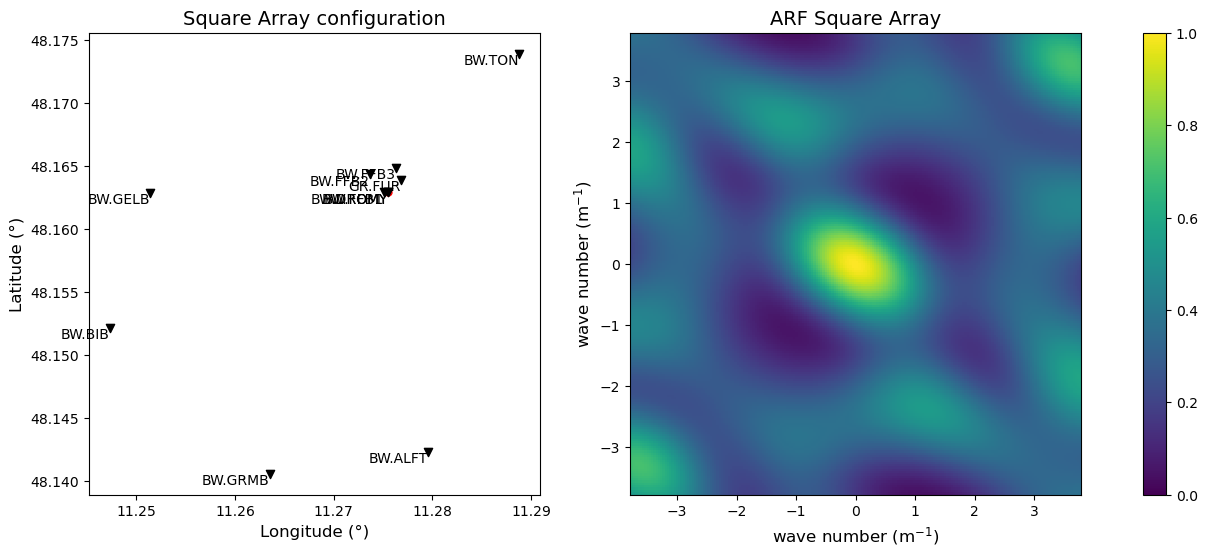

In [14]:
dist, dist_max = __calculateDistanceOfStations(array_stations)


lambda_min = .4*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates, 
                                   config['k_max'], 
                                   config['k_step'], 
                                   coordsys='lonlat'
                                   )

    
__plotArrayGeometryAndResponse(coordinates, 
                               transff, 
                               config['k_max'], 
                               config['k_step'], 
                               array_stations.codes,
                               unit="deg",
                              )

In [ ]:
import pygmt

def __getMapParameters(lats, lons):
    
    # Determine a nice, padded region
    region = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
    x_pad = (region[1] - region[0]) * 0.3
    y_pad = (region[3] - region[2]) * 0.3
    region = [region[0] - x_pad, region[1] + x_pad, region[2] - y_pad, region[3] + y_pad]

    # Determine a nice stereographic projection
    lon_0 = np.mean(region[:2])
    lat_0 = np.mean(region[2:])
    ref_lat = 90 if lat_0 > 0 else -90
    projection = f'S{lon_0}/{ref_lat}/6i'

    return region, projection

region, projection = __getMapParameters(array_stations.lat, array_stations.lon)

fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid='@srtm_relief_01s',
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )
fig.grdimage(**KWARGS)


fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)

fig.text(x=array_stations.lon, 
         y=array_stations.lat, 
         text=[code.split(".")[1] for code in array_stations.codes],
         offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()

In [12]:
import xarray as xr

axis = np.arange(-config['klim'], config['klim']+0.5,0.5)
print( len(axis))

model = xr.DataArray(transff.T, coords=(axis, axis), dims=('lat', 'lon'))


fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid=transff.T,
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )
fig.grdimage(**KWARGS)


fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)

fig.text(x=array_stations.lon, 
         y=array_stations.lat, 
         text=[code.split(".")[1] for code in array_stations.codes],
         offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()

201


NameError: name 'transff' is not defined

In [13]:
transff.T.shape

NameError: name 'transff' is not defined